## Debugging the `LabelModel` with deps + higher-order cliques

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# 052f482ee8732d1d53f6a4cd5c6a47a7009d868b

import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath

from synthetic.generate import SingleTaskTreeDepsGenerator
from metal.label_model import LabelModel
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

### Generating a dataset

In [2]:
# Generate synthetic dataset
np.random.seed(949293)
N = 10000
M = 15
K = 2
EDGE_PROB=1.0
data = SingleTaskTreeDepsGenerator(N, M, k=K, edge_prob=EDGE_PROB)

In [3]:
# mask the diagonals so we don't get influenced by them unfairly
'''sg_no_diag = np.copy(data.sig_inv)
for i in range(M):
    sg_no_diag[i*2:i*2+2,i*2:i*2+2] = np.zeros([2,2])
for j in range(M-1):
    sg_no_diag[2*M+j*4:2*M+j*4+4,2*M+j*4:2*M+j*4+4] = np.zeros([4,4])
'''

print(data.E)
#visualize_matrix(np.abs(data.sig_inv))
#visualize_matrix(np.abs(sg_no_diag))

R_s = np.zeros([1,2])
R_s[0,0] = 1
R_s[0,1] = -1

R = np.zeros([2*M-1, 2*M+4*(M-1)])
m = M

for i in range(m):
    R[i:i+1, 2*i:2*i+2] = R_s

for i in range(m-1):
    R[m+i:m+i+1, 2*m+4*i : 2*m+4*i+2 ] = R_s
    R[m+i:m+i+1, 2*m+4*i+2 : 2*m+4*i+4 ] = R_s

V = np.copy(data.sig_this)

roll = R @ V @ R.T
R_mu = R @ data.mu_true 

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14)]


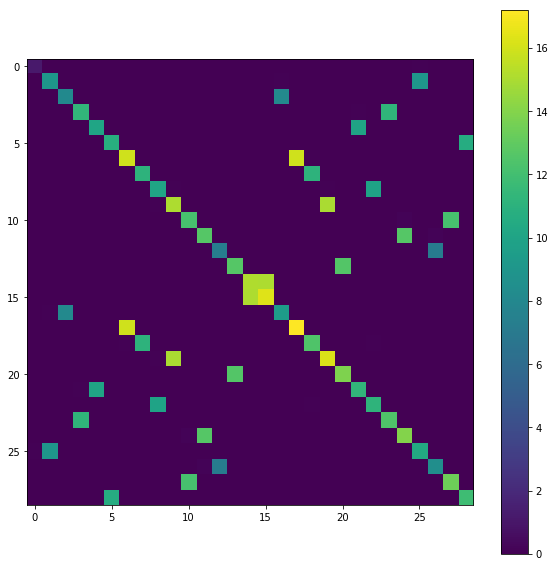

In [4]:
visualize_matrix(np.abs(np.linalg.inv(roll)))

In [5]:
data.k=1
lm = LabelModel(k=data.k, class_balance=data.p)

squashed_O = R @ data.O_true @ R.T

1


In [6]:
# Get the exact O_inv
O_inv = np.linalg.inv(data.O_true)

# Generate c_data: clique data structure
# Normally this is assembled while computing O, but if we pass in O
# ourselves, we need to construct this data structure too...

data.k = 1

lm.train(
    data.L,
    deps=data.E,
    all_unary_cliques=True,
    higher_order_cliques=True,
    n_epochs=50000,
    print_every=5000,
    lr=0.001,
    l2=0,
    O_inv_prec=1024,
    O=squashed_O,
    #O_inv=O_inv,
    c_data=data.c_tree.c_data_1
)

ZZ_true = np.abs(np.linalg.inv(squashed_O) - np.linalg.inv(roll))
ZZ = np.abs(lm.Z.detach().numpy() @ lm.Z.detach().numpy().T)

#print(np.abs(ZZ_true - ZZ))

mu_est = lm.mu.detach().numpy() # Note: we can swap column order
mu_est_swapped = lm.mu.detach().numpy()[:,::-1] # Note: we can swap column order
print(f"Average absolute error: {np.mean(np.abs(mu_est -R_mu))}")
print(f"Average absolute error -- cols swapped: {np.mean(np.abs(mu_est_swapped - R_mu))}")

our k is 1
Estimating Z...
[Epoch 0] Loss: 787.464600
[Epoch 5000] Loss: 0.058140
[Epoch 10000] Loss: 0.058140
[Epoch 15000] Loss: 0.058140
[Epoch 20000] Loss: 0.058140
[Epoch 25000] Loss: 0.058140
[Epoch 30000] Loss: 0.058140
[Epoch 35000] Loss: 0.058140
[Epoch 40000] Loss: 0.058140
[Epoch 45000] Loss: 0.058140
[Epoch 49999] Loss: 0.058140
Estimating \mu...
[Epoch 0] Loss: 1073.772705
[Epoch 5000] Loss: 0.000000
[Epoch 10000] Loss: 0.000000
[Epoch 15000] Loss: 0.000000
[Epoch 20000] Loss: 0.000000
[Epoch 25000] Loss: 0.000000
[Epoch 30000] Loss: 0.000000
[Epoch 35000] Loss: 0.000000
[Epoch 40000] Loss: 0.000000
[Epoch 45000] Loss: 0.000000
[Epoch 49999] Loss: 0.000000
Average absolute error: 0.3322026306331677
Average absolute error -- cols swapped: 0.3322026306331677


In [7]:
print("mu_est")
print(mu_est)

#mu_comb = mu_est[:,0]+mu_est[:,1]

print("\nR_mu\n", np.array(R_mu))
print(f"\nAverage absolute error: {np.mean(np.abs(np.abs(mu_est)-np.abs(R_mu)))}")


mu_est
[[-0.17494003]
 [-0.1012973 ]
 [ 0.21297917]
 [ 0.25409067]
 [ 0.10396322]
 [-0.26736084]
 [-0.11769985]
 [ 0.24854188]
 [ 0.31910253]
 [ 0.1023389 ]
 [-0.0748187 ]
 [ 0.02857596]
 [-0.18400252]
 [-0.28874478]
 [-0.13334401]
 [-0.11928535]
 [ 0.19710033]
 [-0.11631187]
 [ 0.23980275]
 [ 0.0864536 ]
 [-0.27648407]
 [ 0.09031324]
 [ 0.29084453]
 [ 0.22842588]
 [ 0.01879531]
 [-0.09557265]
 [-0.14496298]
 [-0.06749635]
 [-0.23058803]]

R_mu
 [[ 0.17336605]
 [ 0.10741031]
 [-0.22101762]
 [-0.24842976]
 [-0.09425551]
 [ 0.25584557]
 [ 0.11461263]
 [-0.26712011]
 [-0.32921171]
 [-0.10208187]
 [ 0.06554064]
 [-0.01669844]
 [ 0.19021976]
 [ 0.29865679]
 [ 0.13192383]
 [ 0.11682541]
 [-0.2053919 ]
 [ 0.11309   ]
 [-0.25607953]
 [-0.08590931]
 [ 0.28600031]
 [-0.08112996]
 [-0.29861509]
 [-0.22288903]
 [-0.0070916 ]
 [ 0.1008469 ]
 [ 0.15044619]
 [ 0.05814728]
 [ 0.22078591]]

Average absolute error: 0.007508956246242508


[[9.51448611e-04 1.32678533e-03 6.41057204e-04 1.41801304e-03
  1.58871169e-03 5.12409124e-03 6.42922810e-04 5.04051461e-03
  4.50719182e-03 2.81815065e-04 2.89312434e-04 6.94959636e-04
  5.78768594e-04 6.33833298e-04 2.76693290e-03 3.66299499e-03
  2.25194750e-03 1.64154741e-03 1.27695860e-03 9.00949353e-04
  1.09370526e-03 1.45590594e-03 3.15238379e-03 1.28154193e-03
  2.15627294e-03 2.35868005e-04 1.05005283e-04 1.95398607e-03
  1.70749770e-03]
 [1.32678533e-03 5.70641723e-04 8.54143623e-04 2.28818028e-03
  8.15268390e-04 2.09933360e-03 5.06350451e-04 2.01196187e-03
  3.52795427e-03 2.16207114e-03 7.75460283e-04 1.00607374e-03
  2.51786072e-03 1.58240202e-03 2.40326036e-03 1.24242633e-03
  1.38974727e-03 6.11495275e-04 1.37138784e-03 1.55142306e-03
  1.77848572e-03 2.29972592e-04 2.21568041e-04 4.50755697e-04
  1.26711877e-03 4.36571659e-04 5.90830276e-04 4.72874976e-04
  5.48037990e-04]
 [6.41057204e-04 8.54143623e-04 4.31269696e-04 9.60522483e-04
  1.04740290e-03 3.36948693e-03 4.

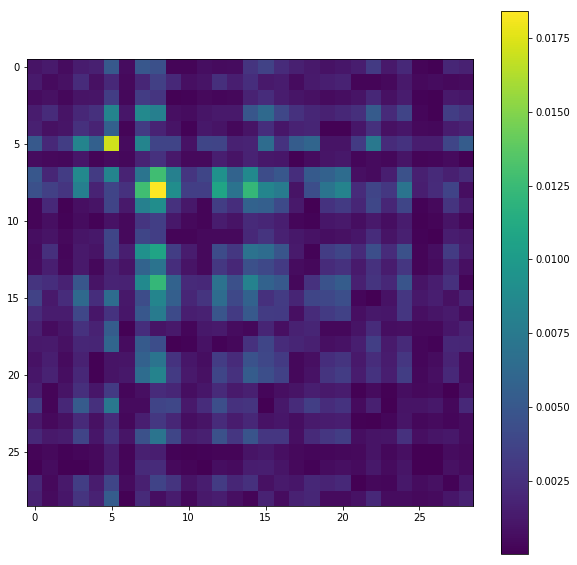

In [8]:
visualize_matrix(np.abs(ZZ_true - ZZ))

print(np.abs(ZZ_true - ZZ))

In [9]:
ZZ_true = np.abs(np.linalg.inv(squashed_O) - np.linalg.inv(roll))
print(ZZ_true)
print("\n\n")
ZZ = np.abs(lm.Z.detach().numpy() @ lm.Z.detach().numpy().T)
print(ZZ)
print("\n\n")

print(np.abs(ZZ_true - ZZ))
print("\n\n")



[[2.36279367e-02 5.49148573e-03 1.52877365e-02 4.01492455e-02
  1.72201207e-02 4.71218200e-02 6.31054967e-03 1.83863652e-02
  4.38937436e-02 3.35733263e-02 1.15351443e-02 1.78452626e-02
  3.84239592e-02 2.34216427e-02 3.07169143e-02 9.87314286e-03
  1.60089072e-02 1.41265596e-02 2.52119751e-02 2.22110497e-02
  2.52979687e-02 2.65406467e-04 4.96327289e-03 3.70954133e-03
  1.43191008e-02 7.56693693e-03 9.66432079e-03 2.25154928e-03
  1.32963604e-02]
 [5.49148573e-03 1.27630338e-03 3.55309852e-03 9.33128489e-03
  4.00221350e-03 1.09518154e-02 1.46666609e-03 4.27326616e-03
  1.02015622e-02 7.80294296e-03 2.68093998e-03 4.14750581e-03
  8.93030257e-03 5.44353992e-03 7.13907011e-03 2.29466601e-03
  3.72070937e-03 3.28322365e-03 5.85963994e-03 5.16218001e-03
  5.87962614e-03 6.16844308e-05 1.15353882e-03 8.62152863e-04
  3.32797311e-03 1.75866927e-03 2.24613264e-03 5.23293713e-04
  3.09027295e-03]
 [1.52877365e-02 3.55309852e-03 9.89146409e-03 2.59773460e-02
  1.11417544e-02 3.04887378e-02 4.

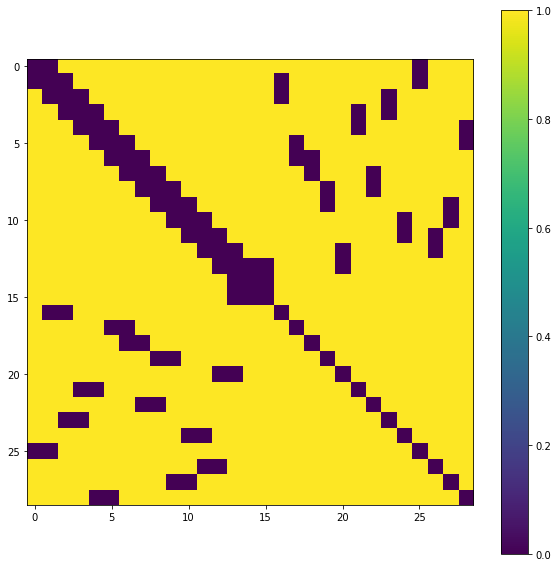

In [10]:
visualize_matrix(lm.mask)

In [ ]:
np.hstack((lm.mu.detach().numpy(), data.mu_true))

In [ ]:
sig_inv_rec = O_inv + (lm.Z @ lm.Z.t()).detach().numpy()
np.linalg.eig(sig_inv_rec)

In [ ]:
A = O_inv - data.sig_inv
B = (lm.Z @ lm.Z.t()).detach().numpy()

print(A)
print(B)

print(np.sum(np.abs(A+B))/(56**2))
visualize_matrix(np.abs(A+B))



In [ ]:
mu = lm.mu.detach().numpy()
diff = np.abs(np.abs(mu @ mu.T) - np.abs(data.mu_true @ data.mu_true.T))
visualize_matrix(diff)
print(diff)


In [ ]:
d2 = np.abs(np.abs(mu[:,::-1]) - np.abs(data.mu_true))
print(d2)
visualize_matrix(d2)

### Training the `LabelModel`

Note that:
* The `train` method assembles other data structures, such as the dependencies junction tree, etc.
* The `higher_order_cliques` kwarg controls whether or not to include them

In [ ]:
lm = LabelModel(k=data.k, class_balance=data.p)

In [ ]:
lm.config['higher_order_cliques'] = True

In [ ]:
'''# Generate the "correct" mu
lm._set_constants(data.L)
lm._set_dependencies(data.E)
mu = compute_mu(lm._get_augmented_label_matrix(data.L.todense()), data.Y, K, data.p)

# Compute O, O_inv, P based on L
lm._generate_O(data.L.todense())
O = lm.O.numpy()
print(O)
d, d = O.shape
O_inv = np.linalg.inv(O)
P = np.diag(data.p)

JJT = np.linalg.inv(np.linalg.inv(P) - mu.T @ O_inv @ mu)
ZZT = O_inv @ mu @ JJT @ mu.T @ O_inv.T'''

In [ ]:
# Check that JJT is indeed PSD ==> ZZT is rank k
#np.linalg.eig(JJT)[0]

In [ ]:
#np.linalg.eig((ZZT + ZZT.T)/2)[0]

In [ ]:
lm.train(
    data.L,
    deps=data.E,
    all_unary_cliques=True,
    higher_order_cliques=True,
    n_epochs=50000,
    print_every=5000,
    lr=0.0001,
    l2=0,
    O_inv_prec=1024,
    #O_inv=ZZT
)

lm._set_constants(data.L)
lm._set_dependencies(data.E)
mu = compute_mu(lm._get_augmented_label_matrix(data.L.todense()), data.Y, K, data.p)


# Test against the true parameter values
mu_est = lm.mu.detach().numpy()
print(mu)
print(mu_est)
print(f"Average absolute error: {np.mean(np.abs(mu_est - mu))}")

### Sanity check that the true $Z$ gets lower loss

In [ ]:
sorted(np.linalg.eig(O)[0])[::-1]

In [ ]:
O = lm.O.numpy()
d, d = O.shape
O_inv = lm.O_inv.numpy()
mask = lm.mask.numpy()
P = lm.P.numpy()

JJT = np.linalg.inv(np.linalg.inv(P) - mu.T @ O_inv @ mu)
ZZT = O_inv @ mu @ JJT @ mu.T @ O_inv.T

np.linalg.norm((O_inv + ZZT) * mask)**2

#### Seed=2

In [ ]:
visualize_matrix(mask)

In [ ]:
#visualize_matrix(np.abs((O_inv + ZZT) * mask))

In [ ]:
lm.c_data

In [ ]:
Z_est = lm.Z.detach().numpy()
visualize_matrix(np.abs((O_inv + Z_est @ Z_est.T) * mask))

#### Seed=1

In [ ]:
visualize_matrix(mask)

In [ ]:
visualize_matrix(np.abs((O_inv + ZZT) * mask))

In [ ]:
Z_est = lm.Z.detach().numpy()
visualize_matrix(np.abs((O_inv + Z_est @ Z_est.T) * mask))

#### Seed=0

In [ ]:
visualize_matrix(mask)

In [ ]:
visualize_matrix(np.abs((O_inv + ZZT) * mask))

In [ ]:
Z_est = lm.Z.detach().numpy()
visualize_matrix(np.abs((O_inv + Z_est @ Z_est.T) * mask))

### Visualizing matrices

In [ ]:
visualize_matrix(np.abs(mu_est - mu))

In [ ]:
visualize_matrix(np.abs(mu_est - mu))

In [ ]:
lm.c_data

In [ ]:
data.E

### Trying to solve with `scipy.optimize.minimize`

In [ ]:
from scipy.optimize import minimize

O_inv = lm.O_inv.numpy()
mask = lm.mask.numpy()

z0 = np.random.randn(lm.d * lm.k)
l import LabelModl import LabelModel
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,el
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
def objective_fn(z):
    Z = z.reshape(-1, data.k)
    return np.linalg.norm( (O_inv + Z @ Z.T) * mask )**2

def gradient_fn(z):
    Z = z.reshape(-1, data.k)
    X = (O_inv + Z @ Z.T) * mask
    return np.ravel(X @ Z)

res = minimize(objective_fn, z0, jac=gradient_fn, method='BFGS')
Z = res['x'].reshape(-1, data.k)
res['fun']

In [ ]:
O = lm.O.numpy()
P = lm.P.numpy()
I_k = np.eye(data.k)
Q = O @ Z @ np.linalg.inv(I_k + Z.T @ O @ Z) @ Z.T @ O

mu0 = np.random.randn(lm.d * lm.k)

def objective_fn_2(mu):
    M = mu.reshape(-1, data.k)
    return np.linalg.norm(Q - M @ P @ M.T)**2 + np.linalg.norm(np.sum(M @ P, 1) - np.diag(O))**2

res_2 = minimize(objective_fn_2, mu0, method='BFGS')
M = res_2['x'].reshape(-1, data.k)
res_2['fun']

In [ ]:
# Test against the true parameter values
print(f"Average absolute error: {np.mean(np.abs(M - mu))}")

## Visualizing the inverse covariance matrix

In [ ]:
J = compute_inv_covariance(
    lm._get_augmented_label_matrix(data.L.todense()),
    data.Y,
    data.k,
    data.p
)
visualize_matrix(np.abs(J))

In [ ]:
visualize_matrix(lm.mask.numpy(), fig_size=[5,5])

In [ ]:
O_inv = lm.O_inv.numpy()
Z = lm.Z.detach().numpy()
mask = lm.mask.numpy()
visualize_matrix(np.abs((O_inv + Z@Z.T) * mask))

### Looking at the internal 'bookkeeping' of cliques...

In [ ]:
lm.c_data

In [ ]:
# Dependency edge weights
[((i,j), data.theta[(i,j)]) for i,j in data.E]